In [1]:
import os
import sys
sys.path.append("../../")

from var_objective.equations import get_pdes
from var_objective.equations import get_pdes
from var_objective.grids import EquiPartGrid
from var_objective.generator import generate_fields
from var_objective.interpolate import estimate_fields
from var_objective.conditions import get_conditions_set
from var_objective.derivative_estimators import get_diff_engine,SplineDiff
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy.interpolate import UnivariateSpline

In [2]:
def get_solution(x0, dxdt0, order=0):
    k = 4.0
    d = 0.5
    k_r = 3.0
    F = 5.0
    denom = (2*d*k*k_r) ** 2 + (k ** 2 - k_r ** 2) ** 2
    partA =  - F * (2*d*k*k_r) / denom
    partB = F * (k ** 2 - k_r ** 2) / denom
    A = x0 - partA
    B = (dxdt0 - partB*k_r + A*d*k) / (k * np.sqrt(1-d**2))
    x = sympy.Symbol('x',real=True)
    traj = sympy.exp(-d*k*x) \
                *(A*sympy.cos(k*sympy.sqrt(1-d**2)*x) \
                + B*sympy.sin(k*sympy.sqrt(1-d**2)*x)) \
                + partA * sympy.cos(k_r*x) \
                + partB * sympy.sin(k_r*x)
    for i in range(order):
        traj = traj.diff()
    
    func = sympy.lambdify([x],traj,'numpy')
    return func

In [3]:
def calculate_errors(max_order):
    global_seed = 0
    np.random.seed(global_seed)
    
    seeds = np.random.randint(0,1000000,size=100)
    
    width = 2.0
    noise_ratio = 0.1
    freq = 20
    
    algs = ['finite','gp']
    
    oscillator = get_pdes("DrivenHarmonicOscillator")
    observed_grid = EquiPartGrid([width], freq)
    full_grid = EquiPartGrid([width],1000)
    
    results_mean = {'finite':[],'spline':[],'gp':[]}
    results_std = {'finite':[],'spline':[],'gp':[]} 
    
    for order in range(max_order+1):
        
        print(f"Order {order}")
        
        order_results = {'finite':[],'spline':[],'gp':[]}
    
        for seed in seeds:

            conditions = get_conditions_set('NumbersRandom2',params={'seed':seed,'num_samples':1})
            x0, dxdt0 = conditions.get_condition_functions(0)
            ground_truth = generate_fields(oscillator, conditions, full_grid, 0.0, seed=seed)
            observed_dataset = generate_fields(oscillator, conditions, observed_grid, noise_ratio, seed=seed)
            t_observed = np.linspace(0,width,freq)
            t_full = np.linspace(0,width,1000)

            if order == 0:
                res = observed_dataset[0,0]
                us = UnivariateSpline(t_observed,res,s=0.01)
                gt_data = get_solution(x0,dxdt0,order=order)(t_observed)
                
                est_spline = us(t_observed)
                error_spline = np.sqrt(np.mean((gt_data-est_spline)**2))
                order_results['spline'].append(error_spline)
                
                est_gp = estimate_fields(observed_grid,observed_dataset,observed_grid,seed=seed)
                error_gp = np.sqrt(np.mean((gt_data-est_gp)**2))
                order_results['gp'].append(error_gp)
                
            else:
                for alg in algs:
                    res = observed_dataset[0,0]
                    engine = get_diff_engine(alg)
                    for i in range(order):
                        res = engine.differentiate(res,observed_grid,0)
                    gt_data = get_solution(x0,dxdt0,order=order)(t_observed)
                    error = np.sqrt(np.mean((gt_data-res)**2))
                    order_results[alg].append(error)
        
        spline_mean = np.mean(order_results['spline'])
        spline_std = np.std(order_results['spline'])
        results_mean['spline'].append(spline_mean)
        results_std['spline'].append(spline_std)
        
        gp_mean = np.mean(order_results['gp'])
        gp_std = np.std(order_results['gp'])
        results_mean['gp'].append(gp_mean)
        results_std['gp'].append(gp_std)
        
        if order == 0:
            results_mean['finite'].append(np.nan)
            results_std['finite'].append(0)
        else:
            finite_mean = np.mean(order_results['finite'])
            finite_std = np.std(order_results['finite'])
            results_mean['finite'].append(finite_mean)
            results_std['finite'].append(finite_std)
        
    return results_mean, results_std

In [4]:
def plot_estimation_errors(ax, res_mean, res_std):
    algs = ['finite','gp']
    display_names = {'finite':'Finite Difference', 'gp':'GP','spline':'Spline'}
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    cmap = {'gt':CB_color_cycle[0],'observed':CB_color_cycle[0],'finite':CB_color_cycle[1],'gp':CB_color_cycle[2],'spline':CB_color_cycle[3]}
    
    xlabel_fontsize = 15
    ylabel_fontsize = 15
    title_fontsize = 15
    legend_fontsize = 15
    ticks_fontsize = 15
    linewidth = 2
    markersize = 5
    max_order = 4
    orders = list(range(max_order+1))

    for alg in algs:
        means = np.array(res_mean[alg][:max_order+1])
        stds = np.array(res_std[alg][:max_order+1])
        ax.plot(orders,means,'o-',label=display_names[alg],c=cmap[alg],linewidth=linewidth,markersize=markersize)
        ax.fill_between(orders,means-stds,means+stds, alpha=0.3, color=cmap[alg])
    #     ax.set_yscale('log')

    ax.set_xlabel('Derivative order', fontsize=ylabel_fontsize)
    ax.set_ylabel('RMSE', fontsize=xlabel_fontsize)
    ax.set_yticks([0,50,100,150,200,250])
    ax.set_yticklabels([0,50,100,150,200,250], fontsize=ticks_fontsize)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels([0,1,2,3,4], fontsize=ticks_fontsize)
#     ax.title.set_text("Derivative estimation error")
#     ax.title.set_fontsize(title_fontsize)
    ax.legend(loc='upper left')
    

In [5]:
def heatmap_errors(ax, results):

    y_axis_labels = [r'$\partial_t^0$',r'$\partial_t^1$',r'$\partial_t^2$']
    x_axis_labels = [r'$\partial_x^0$',r'$\partial_x^1$',r'$\partial_x^2$']

    means = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            means[i,j] = results[(i,j)]['mean']

    im = ax.imshow(means,cmap='plasma')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(x_axis_labels)), labels=x_axis_labels)
    ax.set_yticks(np.arange(len(y_axis_labels)), labels=y_axis_labels)

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_axis_labels)):
        for j in range(len(x_axis_labels)):
            full_text = ('%.2f' % means[i,j]) + r"$\pm$" + ('%.2f' % results[i,j]['std'])
            if i == 2 and j == 2:
                color = 'k'
            else:
                color = 'w'
            text = ax.text(j, i, full_text,
                           ha="center", va="center", color=color)

    ax.tick_params(axis='both', which='major', labelsize=15, labelbottom = False, bottom=False, top = False, labeltop=True)
    
    return im

In [6]:
import warnings
warnings.filterwarnings('ignore')
res_mean, res_std = calculate_errors(4)

Order 0
Order 1
Order 2
Order 3
Order 4


In [7]:
global_seed = 0
np.random.seed(global_seed)

width = 2.0
noise_ratio = 0.01

freq = 20

display_names = {'finite':'Finite Difference', 'gp':'GP','spline':'Spline'}
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00']
cmap = {'gt':CB_color_cycle[0],'observed':CB_color_cycle[0],'finite':CB_color_cycle[1],'gp':CB_color_cycle[2],'spline':CB_color_cycle[3]}

seeds = np.random.randint(0,1000000,size=20)

c = 5

def get_field_func(A,B,order=(0,0)):
    t = sympy.Symbol('t',real=True)
    x = sympy.Symbol('x',real=True)
    expression = A*sympy.sin(x-c*t) + B*sympy.cos(x+c*t)
    derivatives =  [t]*order[0] + [x]*order[1]
    if order != (0,0):
        expression = expression.diff(*derivatives)
    func = sympy.lambdify([(t,x)],expression,'numpy')
    return func

observed_grid = EquiPartGrid([width,width], freq)
engine = get_diff_engine('gp')

indices = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]

results = {}

for index in indices:
    
    errors = []

    for seed in seeds:

        conditions = get_conditions_set('NumbersRandom2',params={'seed':seed,'num_samples':1})
        A, B = conditions.get_condition_functions(0)
        f = get_field_func(A,B,order=(0,0))
        gt_field = f(observed_grid.by_axis())
        
        f = get_field_func(A,B,order=index)
        gt_derivative = f(observed_grid.by_axis())
        
        np.random.seed(seed)
        
        signal = np.std(gt_field)
        observed_field = gt_field + np.random.normal(0,noise_ratio*signal,size=observed_grid.shape)
        
        res = observed_field
        
        if index != [0,0]:
            for i in range(index[0]):
                res = engine.differentiate(res,observed_grid,0)
            for i in range(index[1]):
                res = engine.differentiate(res,observed_grid,1)
        else:
            res = estimate_fields(observed_grid,np.expand_dims(np.expand_dims(res,0),0),observed_grid,seed=seed)
            
        error = np.sqrt(np.mean((gt_derivative-res)**2))
        errors.append(error)
    
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    results[index] = {'mean':error_mean, 'std':error_std}
    

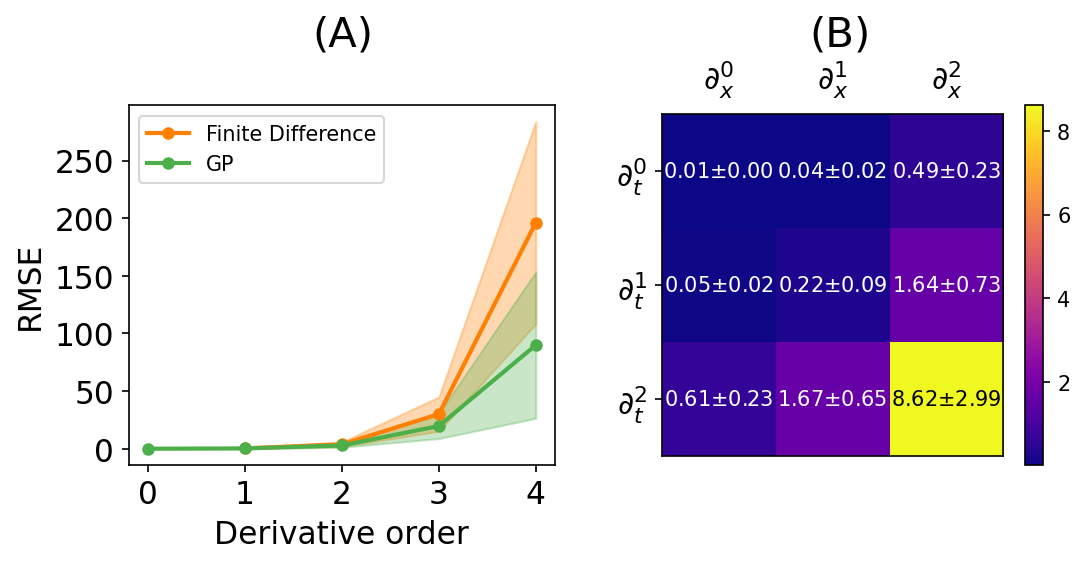

In [8]:
fig, ((ax1,ax2)) = plt.subplots(1,2,figsize=(8,4),dpi=150)

plot_estimation_errors(ax1,res_mean, res_std)
im = heatmap_errors(ax2,results)

plt.colorbar(im, ax=ax2)

plt.subplots_adjust(left=0.15,
                    bottom=0.2, 
                    right=0.95, 
                    top=0.8, 
                    wspace=0.25, 
                    hspace=0.3)

ax1.text(1.7,350,"(A)",fontsize=20)
ax2.text(0.8,-1.1,"(B)",fontsize=20)

# plt.show()
plt.savefig('figures/Figure_11.pdf')